**Enlace al proyecto:**

https://colab.research.google.com/drive/13u1-h0z7MZTVkcZryQXlQzUWNaVNPCSG?usp=sharing

# Reconstrucción de imagenes

**Problema:** crear un algoritmo genético que genere imágenes desde cero, de acuerdo a un 
objetivo establecido.


---



**Liberías a importar**

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image
from random import shuffle 

import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import random

**Cargar archivos**

Nota: Solo se debe cargar una imagen en formato jpg, en caso de cargar varias imagenes, se escogerá la primer imagen seleccionada.

In [ ]:
def upload_file():
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [ ]:
namefiles = upload_file()
im = Image.open(namefiles[0])

Saving bigotes-de-gato-100x100.jpg to bigotes-de-gato-100x100 (1).jpg


# Pre-procesamiento de la imagen

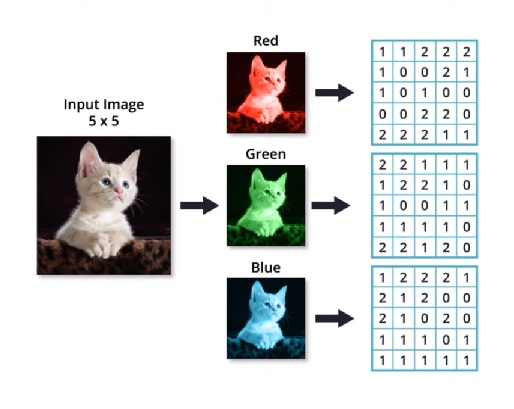

**Procesamiento de la imagen:**

In [ ]:
img_array = np.asarray(im)

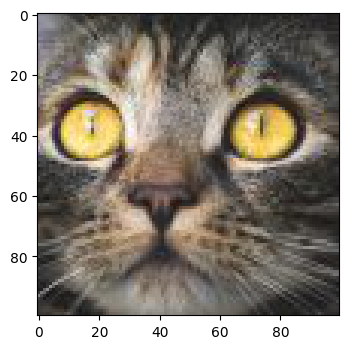

In [ ]:
plt.figure(dpi=100)
plt.imshow(img_array)

**Conversión del image array a un cromosoma**

In [ ]:
#Parametros Globales
width, height, channel = img_array.shape #se almacena la forma de la imagen para después hacer el proceso inverso
cromosoma_objetivo = None
#_______________________________________________________________________________________________________________
print("Ancho: " + str(width) + ", Alto: " + str(height) + ", canales: " + str(channel))

#conversión img-array a cromosoma
cromosoma_objetivo = img_array
cromosoma_objetivo = cromosoma_objetivo.reshape(width*height*channel)
print("número de genes por cromosoma: "+str(cromosoma_objetivo.shape[0]))

Ancho: 100, Alto: 100, canales: 3
número de genes por cromosoma: 30000


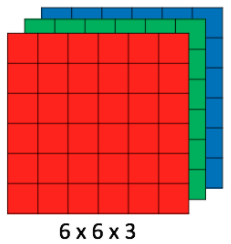

**Función que convierte un cromosoma a un img Array** 

In [ ]:
def cromo_to_img_array(img_cromosoma):
  return img_cromosoma.reshape(width, height, channel)

# Población Inicial

In [ ]:
def generar_poblacion():
  poblacion_vacia = []
  for cromosoma in range(0, poblacion_inicial):#poblacion_inicial = 16
     poblacion_vacia.append(np.around(np.random.random(width*height*channel)*256).astype(int))
  return poblacion_vacia

# Función Fitness

**Definición de la función:** Para determinar la calidad de un cromosoma individuo de la población se usan las formulas de la siguiente imagen, donde N es el total de genes del cromosoma. La calidad se se define como la media del valor absoluto de la diferencia entre un cromosoma objetivo (meta del algoritmo) y un cromosoma individuo de la población.

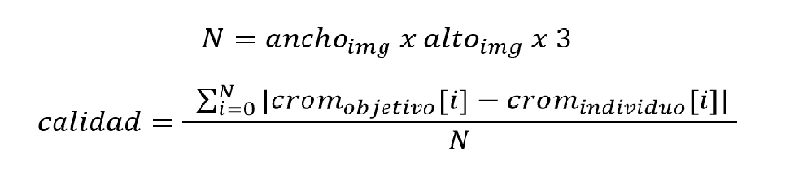

Si la calidad del cromosoma tiende a 0, esto nos indica que el cromosoma objetivo y el cromosoma individuo son muy similares, por lo que, la mejor calidad, siempre será el valor mas cercano a 0.



In [ ]:
def funcion_fitness(cromosoma_objetivo, cromosoma_individuo):
  return np.mean(np.abs(cromosoma_objetivo-cromosoma_individuo)) #calidad


Por otro lado, tenemos la función `calcular_fitness_población` que evalua la función fitness con cada individuo de la población y retorna una matriz con la calidad de cada individuo.

In [ ]:
def calcular_fitness_poblacion(poblacion):
  calidad_array = np.zeros(poblacion.__len__()) 
  for individuo in range(0, poblacion.__len__()):
    calidad_array[individuo] = funcion_fitness(cromosoma_objetivo, 
                                         poblacion[individuo])
  return calidad_array

# Selección de padres (mating-pool)

**Criterio de Selección:** Se seleccionará de la mitad de la población aquellos cromosomas que tengan la mejor calidad arrojada por la función fitness. una vez guardado el cromosoma que hará de padre, su valor de calidad es seteado 256 para que no se tenga en cuenta para las siguientes iteraciones.

la funcion `funcion_mating_pool` retorna un arreglo con los padres seleccionados a partir del criterio definido anteriormente.

In [ ]:
def funcion_mating_pool(poblacion, calidad_array, num_padres):
  
  padres_array = np.zeros((num_padres, width*height*channel), dtype=int)

  for padre_indice in range(0, num_padres):
    min_calidad_indice = np.argmin(calidad_array)
    padres_array[padre_indice] =  poblacion[min_calidad_indice]
    calidad_array[min_calidad_indice] = 256

  return padres_array

# Cruce

In [ ]:
def cruce (padres, num_individuos):

  nueva_poblacion = []

  #Guardo los padres en la nueva generación de individuos
  for padre in padres:
    nueva_poblacion.append(padre)

  #determino una lista con el número de padres para hacer las posibles
  #permutaciones
  lista_indices=[]
  for i in range(0, np.size(padres,0)):
    lista_indices.append(i);

  lista_permutaciones = list(itertools.permutations(lista_indices, r =2))
  #revuelvo la lista
  shuffle(lista_permutaciones)

  #defino el numero de nuevos cromosomas
  num_nuevos_cromosomas = num_individuos - np.size(padres,0)
  #defino el punto de corte para los cromosomas hijos
  punto_corte = (int)((width*height*channel)/2)

  for i in range(0, num_nuevos_cromosomas):
    cromosoma_hijo= np.zeros(width*height*channel, dtype=int)

    cromosoma_hijo[0:punto_corte] =  padres[lista_permutaciones[i][0]][0:punto_corte]
    cromosoma_hijo[punto_corte:] =  padres[lista_permutaciones[i][1]][punto_corte:]
    nueva_poblacion.append(cromosoma_hijo)
    #de cada padre, el cromosoma hijo tomará el 50% de los genes de cada uno.
  return nueva_poblacion


# Mutación

In [ ]:
def determinar_mutacion(gen, porcentaje_mutacion):
  if random.random()<= porcentaje_mutacion:
    return (int) (random.random()*256)
  return gen

In [ ]:
def mutar(poblacion, num_padres, porcentaje_mutacion):

  poblacion_mutada = []

  for i in range(0, num_padres):
    poblacion_mutada.append(poblacion[i])

  for i in range(num_padres,poblacion.__len__()):
    cromosoma_fun = np.vectorize(determinar_mutacion)
    cromosoma_mutado = cromosoma_fun(poblacion[i], porcentaje_mutacion)
    poblacion_mutada.append(cromosoma_mutado)
    
  return poblacion_mutada

# Algoritmo Genético:

In [ ]:
#Parametro Global
poblacion_inicial = 16

#Se genera la población inicial de Individuos
poblacion = generar_poblacion()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

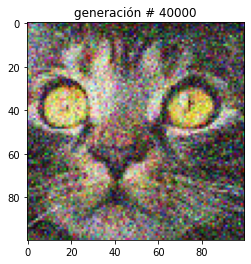

In [ ]:
#Contador para indicar cuando guardar la imagen del mejor cromosoma actual
#en la simulación
contador=1000
#Inicia la simulación en la generación #0
for i in range(1,40002):

  #Se calcula las funciones fitness de las población actual
  calidad_array = calcular_fitness_poblacion(poblacion)

  #cada 1000 generaciones se guarda una imagen del mejor cromosoma actual_________________________
  if(contador==1000):
    max_calidad_indice = np.argmin(calidad_array) 

    #Se convierte el cromosoma a imagen:
    mejor_cromosoma = cromo_to_img_array(poblacion[max_calidad_indice])

    plt.title('generación # '+ str(i-1) )
    plt.imshow(mejor_cromosoma)
    plt.savefig('MejorCromosoma_'+ str(i-1) +'.png')
    contador = 0
  #______________________________________________________________________________________________

  #Se obtienen aquellos padres que tuvieron el mejor puntaje en la función
  #fitness
  num_padres = (int)(poblacion.__len__()/2)
  padres = funcion_mating_pool(poblacion.copy(), calidad_array, num_padres)
  #De los padres seleccionados, se crea la nueva población de individuos
  poblacion = cruce(padres.copy(),poblacion_inicial)

  #Proceso de mutación de los nuevos cromosomas
  poblacion = mutar(poblacion.copy(), np.size(padres,0), 0.00008)

  contador+=1

# Referencias:

**Tutorial Referencia para la realización de este trabajo:**

https://heartbeat.comet.ml/reproducing-images-using-a-genetic-algorithm-with-python-91fc701ff84

**Documentación de numpy para la consulta de funcionalidades y utilidades:**

https://numpy.org/doc/

---

**Algoritmo genético para la restauración de imagenes dígitales**

http://alojamientos.us.es/gtocoma/pid/pid10/alggenrestauracion.htm